In [7]:
"""

starfish school example, comparing simple spline (e.g. cubic) to Gaussian Process regression. The GP example is from 
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause.

========================================================
Comparison between linear, cubic spline and GP regression 

For the spline ....

 
A simple one-dimensional regression example computed in two different ways:

1. A noise-free case
2. A noisy case with known noise-level per datapoint

In both cases, the kernel's parameters are estimated using the maximum
likelihood principle.

The figures illustrate the interpolating property of the Gaussian Process
model as well as its probabilistic nature in the form of a pointwise 95%
confidence interval.

Note that the parameter ``alpha`` is applied as a Tikhonov
regularization of the assumed covariance between the training points.

"""

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
np.random.seed(1)


In [8]:
def f(x):
    """The true function."""
    return x * np.sin(x)


def ff(x,a, b):
    """The function to predict with two variables."""
    return a*x * np.sin(b*x)


[1. 1.] fit params in the noise-free case


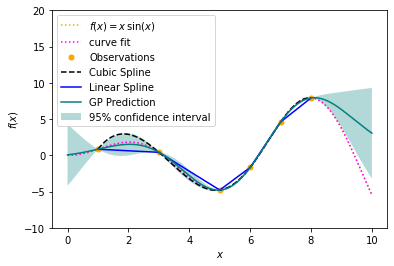

In [9]:
# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel() #-- Return a contiguous flattened array 

ysplinefunc = interp1d(X.ravel(), y, kind='cubic')
ysplinefunclin = interp1d(X.ravel(), y, kind='linear')

xvec = X.ravel()


# Use the curve_fit function and fit for the best-fit parameters and error
fitparams, fiterror  =  curve_fit(ff,xvec,y)
print(fitparams, 'fit params in the noise-free case')
# Now let's do the Gaussian Process 
# Mesh the input space for evaluations of the real function, the prediction and
# its Mean Square Error (MSE)




# Instantiate a Gaussian Process model. This Radial-basis function (RBF) kernel 
# is multi-variate gaussian drop off,  parameterized by a length scale parameter , which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs X (anisotropic variant of the kernel). 

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# This is how the GP regressor is called
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

x = np.atleast_2d(np.linspace(0, 10, 1000)).T
# Fit to data using Maximum Likelihood Estimation of the parameters
# now we can use this to do the fit of the parameters in the GP 
gp.fit(X, y)


# Now given the new meshed x axis we can get a prediction of the y value and it's error
y_pred, sigma = gp.predict(x, return_std=True)

# Now splining 
xx = np.linspace(np.min(X), np.max(X), 1000)

yspline = ysplinefunc(xx.ravel()) # cubic spline
ysplinelin = ysplinefunclin(xx.ravel()) # linear spline



# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(x, f(x), ':', color='orange',label=r'$f(x) = x\,\sin(x)$')
plt.plot(x,ff(x,fitparams[0], fitparams[1]), ':', color='magenta', label='curve fit')
plt.plot(X, y, marker='.', color='orange',markersize=10, label='Observations', linestyle='None')
plt.plot(xx, yspline, '--k', label='Cubic Spline')
plt.plot(xx, ysplinelin, '-',color='blue', label='Linear Spline')
plt.plot(x, y_pred, '-',color='teal', label='GP Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='teal', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')


[1.03885505 0.9997822 ] fit params in noisy case


<Figure size 432x288 with 0 Axes>

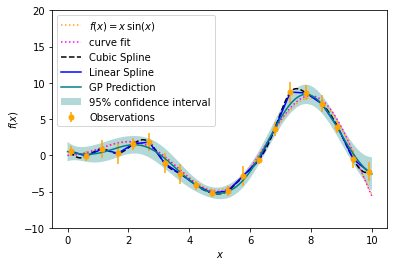

In [10]:
# ----------------------------------------------------------------------
# now the noisy case
X = np.linspace(0.1, 9.9, 20)
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Curve fit
fitparams, fiterror  =curve_fit(ff,X.ravel(),y)

# We can see how the fitparams are returned 
print(fitparams, 'fit params in noisy case')
xx = np.linspace(np.min(X), np.max(X), 1000)

ysplinefunc = interp1d(X.ravel(), y, kind='cubic')
ysplinefunclin = interp1d(X.ravel(), y, kind='linear')
yspline = ysplinefunc(xx.ravel())
ysplinelin = ysplinefunclin(xx.ravel())

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Splining
ysplinefunc = interp1d(X.ravel(), y, kind='cubic')
ysplinefunclin = interp1d(X.ravel(), y, kind='linear')


# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.clf()
plt.figure()
plt.plot(x, f(x), ':', color='orange',label=r'$f(x) = x\,\sin(x)$')
plt.plot(x,ff(x,fitparams[0], fitparams[1]), ':', color='magenta', label='curve fit')
plt.errorbar(X.ravel(), y, dy, fmt='.', color='orange',markersize=10, label='Observations', linestyle='none')
plt.plot(xx, yspline, '--k', label='Cubic Spline')
plt.plot(xx, ysplinelin, '-',color='blue', label='Linear Spline')
plt.plot(x, y_pred, '-', color='teal',label='GP Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='teal', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
